In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd

In [2]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [3]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [4]:
modelC = Unet(14, (200, 600, 3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 600, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

                                                                                                  
 block4_conv2 (Conv2D)          (None, 25, 75, 512)  2359808     ['activation_7[0][0]']           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 25, 75, 512)  2048       ['block4_conv2[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 25, 75, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 block4_conv3 (Conv2D)          (None, 25, 75, 512)  2359808     ['activation_8[0][0]']           
                                                                                                  
 batch_nor

                                8)                                'activation_1[0][0]']           
                                                                                                  
 conv2d_4 (Conv2D)              (None, 200, 600, 64  73792       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 200, 600, 64  256        ['conv2d_4[0][0]']               
 ormalization)                  )                                                                 
                                                                                                  
 activation_17 (Activation)     (None, 200, 600, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
          

### Датасет
Используется https://www.kaggle.com/c/tgs-salt-identification-challenge/data

In [5]:
PAHT_label = 'masks/'
PAHT_image = 'images/'

In [6]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [7]:
imag,imag_label

(['44381a3f55.png',
  '70db04a203.png',
  '42c563d895.png',
  'd422a9eb8f.png',
  '6d4fca6a35.png',
  '7ebd3f0cdd.png',
  '99d7f0c538.png',
  'f43f1e7456.png',
  'c756ff4e1f.png',
  'ff238df1c4.png',
  '1f33387a8e.png',
  'fefe01ac32.png',
  '8d70a676cd.png',
  'aa1c0ba47b.png',
  '88839f49f9.png',
  '343b0359b5.png',
  '13f448be07.png',
  '331ec135dd.png',
  '81e9af5ee2.png',
  '56ab4fae30.png',
  '6abe55deaf.png',
  '822043d604.png',
  'c82ae5f941.png',
  '4cfee4b097.png',
  '6074c5b0bf.png',
  '576fd5de16.png',
  'e23a93a95e.png',
  '28948eeb9c.png',
  'e6674212ce.png',
  '1b5a148cd3.png',
  'ea1332b03d.png',
  'd18a64f984.png',
  '1c37e37fbf.png',
  '071d5aa17f.png',
  '27870bb184.png',
  '6d8a8e2e6d.png',
  '08c2070b20.png',
  'a15b73d4bb.png',
  '336e1995cd.png',
  '974f5b6876.png',
  'd14ad5cb55.png',
  'e0bde1cf11.png',
  'e7c54b5f4e.png',
  '3fc4d6b6ed.png',
  '77420e5628.png',
  '0be923c49b.png',
  'd768234bb5.png',
  'f2f67e14a6.png',
  '314db606fd.png',
  'ad2fa649f7.png',


In [8]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

In [9]:
sample_item = 150

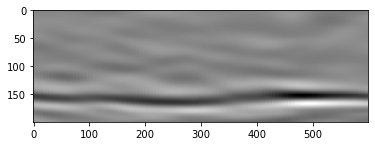

In [10]:
plt.imshow(images[sample_item].convert('RGBA'))
plt.show()

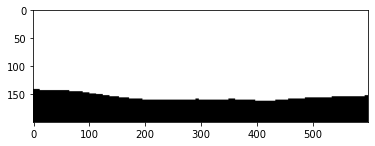

In [11]:
plt.imshow(segments[sample_item].convert('RGBA'))
plt.show()

In [12]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [13]:
xTrain_Test.shape

(4000, 200, 600, 3)

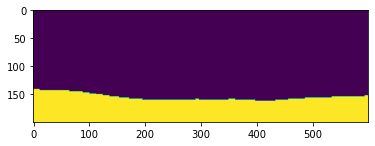

In [14]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[sample_item]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

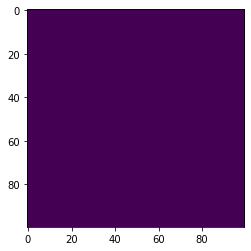

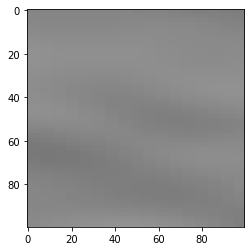

In [15]:
plt.imshow(cat_yi[:100,:100,3])
plt.show()
plt.imshow(xTrain_Test[sample_item,:100,:100,:]/255)
plt.show()

In [16]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [17]:
yTrain_Test.shape

(4000, 200, 600, 14)

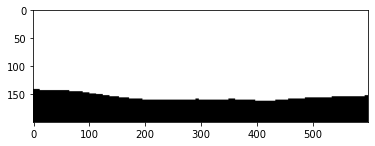

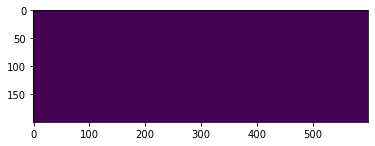

In [18]:
n = 150
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

In [19]:
N = int(yTrain_Test.shape[0] * 0.8)
N

3200

In [20]:
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [ ]:
history = modelC.fit(xTrain, yTrain, epochs=2, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/2
 213/3200 [>.............................] - ETA: 8:01:32 - loss: 0.0571 - dice_coef: 0.7616